In [56]:
# noexport

!typech retention_utils.ipynb

[NbConvertApp] Converting notebook retention_utils.ipynb to python
retention_utils.py:257: error: invalid syntax


In [2]:
import pandas as pd

import rpy2.situation
rpy2.situation.get_r_home()

import rpy2
from rpy2.robjects import r

from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [3]:
from train_utils import *

In [4]:
@msgpackmemo
def get_install_to_dates_active_list():
  output = {}
  for install,dates_active_set in get_install_to_dates_active_set().items():
    dates_active_list = sorted(list(dates_active_set))
    output[install] = dates_active_list
  return output

In [5]:
def get_install_to_dates_active_set():
  install_active_dates = get_collection_items('install_active_dates')
  output = {}
  #weird_items = []
  for item in install_active_dates:
    if 'day' not in item or 'install' not in item:
      #weird_items.append(item)
      continue
    day = item['day']
    install = item['install']
    if install not in output:
      output[install] = set()
    output[install].add(day)
  #print(len(weird_items))
  #print(weird_items[:100])
  return output

#print(user_active_dates[0])

In [6]:
@msgpackmemo
def get_user_to_dates_active_list():
  output = {}
  for user,dates_active_set in get_user_to_dates_active_set().items():
    dates_active_list = sorted(list(dates_active_set))
    output[user] = dates_active_list
  return output

In [7]:
def get_user_to_dates_active_set():
  user_active_dates = get_collection_items('user_active_dates')
  output = {}
  #weird_items = []
  for item in user_active_dates:
    if 'day' not in item or 'user' not in item:
      #weird_items.append(item)
      continue
    day = item['day']
    user = item['user']
    if user not in output:
      output[user] = set()
    output[user].add(day)
  #print(len(weird_items))
  #print(weird_items[:100])
  return output

#print(user_active_dates[0])

In [8]:
def get_date_to_users_active_set():
  output = {}
  for user,dates_active_list in get_user_to_dates_active_list().items():
    for date in dates_active_list:
      if date not in output:
        output[date] = set()
      output[date].add(user)
  return output

In [9]:
@msgpackmemo
def get_date_to_users_active_list():
  output = {}
  for date,users_active_set in get_date_to_users_active_set().items():
    output[date] = sorted(list(users_active_set))
  return output

In [10]:
def get_date_to_installs_active_set():
  output = {}
  for install,dates_active_list in get_install_to_dates_active_list().items():
    for date in dates_active_list:
      if date not in output:
        output[date] = set()
      output[date].add(install)
  return output

In [11]:
@msgpackmemo
def get_date_to_installs_active_list():
  output = {}
  for date,installs_active_set in get_date_to_installs_active_set().items():
    output[date] = sorted(list(installs_active_set))
  return output

In [12]:
from datetime import datetime
from dateutil import tz

def get_epoch_start_arrowdate():
  return arrow.get(datetime(2016, 1, 1)) #, tz.gettz('US/Pacific'))

def convert_date_to_arrowdate(date):
  year = int(date[0:4])
  month = int(date[4:6])
  day = int(date[6:8])
  return arrow.get(datetime(year, month, day)) #, tz.gettz('US/Pacific'))

def get_dump_date():
  return sorted(list(get_date_to_users_active_list().keys()))[-1]

def get_dump_arrowdate():
  dump_date = get_dump_date()
  return convert_date_to_arrowdate(dump_date)

def get_dump_epoch():
  dump_arrowdate = get_dump_arrowdate()
  return convert_arrowdate_to_epoch(dump_arrowdate)

def convert_arrowdate_to_epoch(arrowdate):
  return (arrowdate - get_epoch_start_arrowdate()).days

def convert_date_to_epoch(date):
  arrowdate = convert_date_to_arrowdate(date)
  return convert_arrowdate_to_epoch(arrowdate)

In [13]:
@msgpackmemo
def get_user_to_retention_info():
  output = {}
  dump_epoch = get_dump_epoch()
  for user,dates_active in get_user_to_dates_active_list().items():
    epochs_active = sorted([convert_date_to_epoch(x) for x in dates_active])
    first_active = epochs_active[0]
    last_active = epochs_active[-1]
    days_alive = last_active - first_active
    is_alive = (dump_epoch - last_active) <= 4
    attritioned = not is_alive
    output[user] = {'lifetime': days_alive, 'attritioned': attritioned}
  return output

In [14]:
def to_dataframe(list_of_dict):
  columns = list(list_of_dict[0].keys())
  d = {}
  for column in columns:
    d[column] = []
    for item in list_of_dict:
      d[column].append(item[column])
  return pd.DataFrame(d)


In [15]:
def get_all_user_retentions_dataframe():
  user_retentions = []
  for user,retention_info in get_user_to_retention_info().items():
    user_retentions.append(retention_info)
  return to_dataframe(user_retentions)

In [44]:
def get_abtest_experiment_conditions(user):
  items = get_collection_for_user(user, 'synced:experiment_vars')
  output = {}
  for x in items:
    if 'conditions' not in x:
      continue
    key = x['key']
    conditions = x['conditions']
    output[key] = conditions
  return output



In [45]:
def get_retention_info_by_frequency_of_choose_difficulty():
  output = []
  user_list = get_users_with_choose_difficulty()
  user_to_retention_info = get_user_to_retention_info()
  for user in user_list:
    abtest_settings = get_abtest_settings(user)
    frequency_of_choose_difficulty = abtest_settings.get('frequency_of_choose_difficulty')
    if frequency_of_choose_difficulty == None:
      continue
    conditions = get_abtest_experiment_conditions(user).get('frequency_of_choose_difficulty')
    if conditions != ['0.0', '0.25', '0.5', '1.0']:
      continue
    retention_info = user_to_retention_info[user]
    output.append({
      'lifetime': retention_info['lifetime'],
      'attritioned': retention_info['attritioned'],
      'frequency_of_choose_difficulty': frequency_of_choose_difficulty,
    })
  return to_dataframe(output)

In [46]:
df = get_retention_info_by_frequency_of_choose_difficulty()

In [47]:
r.assign('df', df)

,lifetime,attritioned,frequency_of_choose_difficulty
0,207,1,1.0
1,0,1,0.0
2,150,0,1.0
3,3,1,0.5
4,149,0,1.0
5,345,0,0.5
6,96,1,0.25
7,303,0,0.0
8,149,0,1.0
9,167,0,1.0


In [31]:
r('''
library("survival")
library("survminer")
''')

array(['survminer', 'ggpubr', 'magrittr', 'ggplot2', 'survival', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U9')

In [16]:
#def plot_retention(df):
  

SyntaxError: unexpected EOF while parsing (<ipython-input-16-264e717a6c04>, line 2)

In [25]:
df = get_all_user_retentions_dataframe()
r.assign('df', df)

,lifetime,attritioned
0,461,0
1,457,0
2,457,0
3,323,1
4,61,1
5,111,1
6,99,1
7,215,1
8,130,1
9,198,1


In [18]:
print(df)

       lifetime  attritioned
0           461        False
1           457        False
2           457        False
3           323         True
4            61         True
5           111         True
6            99         True
7           215         True
8           130         True
9           198         True
10          261         True
11          438        False
12           82         True
13          236         True
14            6         True
15          193         True
16          350         True
17          213         True
18          201         True
19          235         True
20          292         True
21          194         True
22           52         True
23           98         True
24           94         True
25           48         True
26          207         True
27          344         True
28          290         True
29          253         True
...         ...          ...
22560         0        False
22561         1        False
22562         

In [22]:
r('''
install.packages("survival")
''')

  trying to use CRAN without setting a mirror
Calls: <Anonymous> -> <Anonymous> -> install.packages -> contrib.url



RRuntimeError: Error in contrib.url(repos, "source") : 
  trying to use CRAN without setting a mirror
Calls: <Anonymous> -> <Anonymous> -> install.packages -> contrib.url


array(['Min.   :  0.00  ', '1st Qu.:  1.00  ', 'Median : 33.00  ',
       'Mean   : 86.78  ', '3rd Qu.:112.00  ', 'Max.   :685.00  ',
       'Mode :logical  ', 'FALSE:5677     ', 'TRUE :16913    ', 'NA',
       'NA', 'NA'], dtype='<U16')

In [48]:
r('''
library("survival")
library("survminer")
fit <- survfit(Surv(lifetime, attritioned) ~ frequency_of_choose_difficulty, data=df)
summary(fit)
''')

n,[ 80 197 213 216]
time,[ 0. 1. 2. 3. 5. 9. 10. 11. 14. 16. 19. 22. 31. 35. 40. 46. 55. 68. 70. 111. 117. 121. 128. 130. 146. 159. 162. 179. 263. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 13. 15. 16. 22. 23. 24. 25. 27. 28. 29. 32. 35. 36. 37. 39. 42. 48. 54. 56. 57. 63. 65. 70. 71. 72. 76. 77. 82. 83. 84. 92. 93. 95. 96. 100. 101. 102. 104. 108. 111. 116. 118. 132. 140. 142. 151. 176. 195. 224. 270. 273. 304. 335. 345. 347. 421. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 21. 23. 24. 27. 28. 29. 33. 34. 37. 39. 40. 42. 44. 46. 48. 49. 51. 54. 56. 63. 64. 65. 66. 67. 71. 72. 79. 83. 87. 92. 95. 97. 99. 100. 101. 103. 104. 106. 112. 113. 114. 120. 130. 135. 136. 138. 150. 171. 186. 189. 196. 213. 240. 247. 255. 278. 359. 382. 395. 435. 0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 11. 12. 13. 14. 15. 16. 17. 18. 19. 21. 23. 24. 26. 27. 28. 29. 31. 35. 36. 38. 39. 41. 42. 44. 45. 46. 49. 57. 58. 59. 61. 63. 66. 72. 73. 74. 76. 80. 84. 86. 87. 92. 99. 100. 102. 103. 106. 108. 111. 113. 118. 127. 131. 134. 139. 165. 180. 183. 202. 203. 207. 254. 272. 321. 323. 328. 344. 439. 449. 496.]
n.risk,[ 80. 78. 76. 75. 73. 69. 68. 66. 64. 63. 62. 60. 58. 57. 56. 55. 54. 53. 52. 51. 49. 47. 39. 35. 29. 25. 24. 22. 17. 197. 191. 187. 183. 182. 180. 178. 177. 176. 175. 173. 170. 166. 164. 163. 162. 161. 160. 158. 157. 155. 153. 152. 151. 150. 149. 148. 146. 144. 143. 142. 141. 140. 138. 137. 136. 135. 132. 130. 129. 128. 125. 124. 122. 121. 120. 119. 117. 112. 107. 102. 94. 92. 60. 49. 47. 42. 37. 33. 28. 18. 17. 14. 12. 11. 10. 7. 213. 204. 195. 192. 188. 187. 184. 181. 180. 179. 178. 177. 174. 173. 171. 169. 166. 165. 164. 163. 160. 159. 158. 156. 155. 153. 152. 150. 149. 147. 146. 144. 143. 141. 140. 138. 136. 135. 134. 131. 130. 129. 127. 126. 124. 120. 118. 117. 116. 114. 113. 112. 111. 110. 109. 107. 100. 87. 84. 80. 73. 55. 49. 47. 44. 32. 29. 27. 25. 24. 21. 20. 18. 16. 11. 7. 6. 5. 2. 216. 199. 197. 194. 191. 189. 184. 182. 181. 178. 175. 174. 172. 171. 167. 166. 162. 161. 159. 158. 155. 154. 153. 151. 150. 149. 147. 146. 145. 143. 142. 139. 136. 133. 131. 130. 129. 128. 127. 125. 124. 123. 121. 120. 119. 118. 117. 115. 114. 113. 112. 111. 109. 108. 106. 105. 98. 92. 86. 82. 77. 64. 58. 52. 49. 35. 32. 31. 27. 26. 25. 22. 17. 13. 12. 10. 8. 6. 5. 2.]
...,...
call,[RTYPES.LANGSXP]
table,[[ 80. 80. 80. 39. 270.06603366 27.87244821 179. 128. nan] [197. 197. 197. 102. 233.38849518 18.62835199 176. 111. 335. ] [213. 213. 213. 130. 175.60336723 15.71205654 106. 79. 150. ] [216. 216. 216. 138. 176.39370595 15.47560071 99.5 63. 139. ]]
rmean.endtime,[515.5 515.5 515.5 515.5]


In [51]:
%load_ext rpy2.ipython


In [62]:
%%R
df$lifetime <- as.numeric(df$lifetime)
df$attritioned <- as.logical(df$attritioned)
df$frequency_of_choose_difficulty <- as.factor(df$frequency_of_choose_difficulty)

In [63]:
%%R
summary(df)

 [1] "Min.   :  0.00  " "1st Qu.: 24.25  " "Median :106.00  " "Mean   :111.37  "
 [5] "3rd Qu.:136.00  " "Max.   :625.00  " "Mode :logical  "  "FALSE:297      " 
 [9] "TRUE :409      "  "NA"               "NA"               "NA"              
[13] "0.0 : 80  "       "0.25:197  "       "0.5 :213  "       "1.0 :216  "      
[17] "NA"               "NA"              


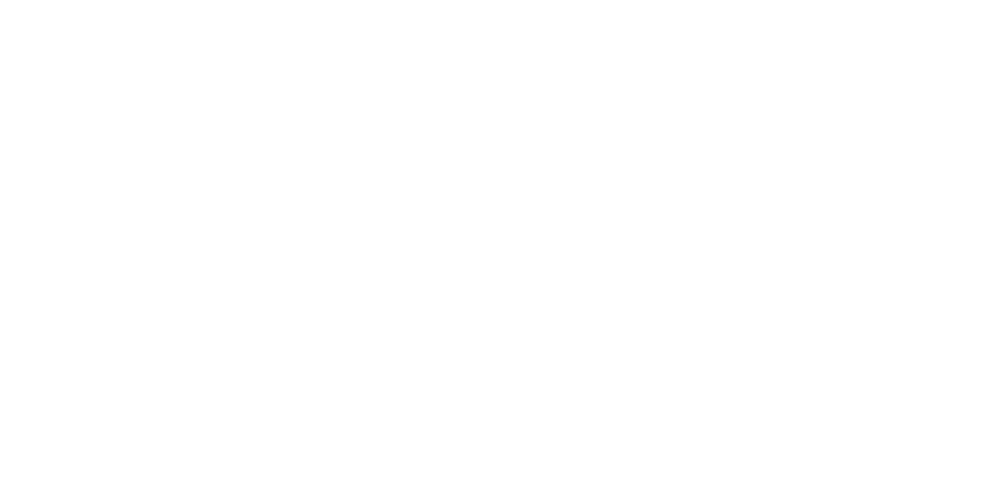

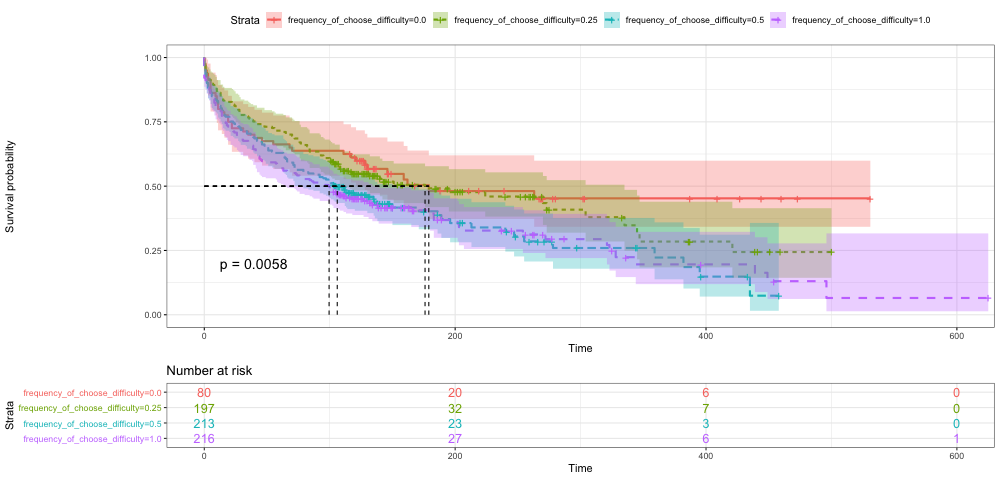

In [55]:
%%R -w 1000
ggsurvplot(fit,
          pval = TRUE, conf.int = TRUE,
          risk.table = TRUE, # Add risk table
          risk.table.col = "strata", # Change risk table color by groups
          linetype = "strata", # Change line type by groups
          surv.median.line = "hv", # Specify median survival
          ggtheme = theme_bw(), # Change ggplot2 theme
)


In [ ]:
print(get_all_user_retentions_dataframe())

In [ ]:
to_dataframe([{'a': 3, 'b': 5}, {'a': 4, 'b': 6}])

In [ ]:
r.assign('a', to_dataframe([{'a': 3, 'b': 5}, {'a': 4, 'b': 6}]))

In [ ]:
#r.assign('a', 5)
r('''show(a)''')

In [ ]:
r('''a <- 3''')
